In [22]:
import spacy
import pandas as pd
import en_core_web_sm
import matplotlib.pyplot as plt
import re
import seaborn as sns
from scipy import stats
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.tree import plot_tree
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

pd.set_option('display.max_columns', 100)

In [23]:
df = pd.read_csv('../data.csv')

In [24]:
# we need our data sorted chronologically
df = df.sort_values(by = 'game_date')

In [25]:
df.head(25)

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
22901,Jump Shot,Jump Shot,102,29600027,33.9283,-140,116,-118.4098,0,1,0,1996-97,42,18,0.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,1996-11-03,LAL vs. MIN,MIN,22902
22902,Jump Shot,Jump Shot,127,29600031,33.9473,-131,97,-118.4008,10,2,0,1996-97,8,16,0.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,1996-11-05,LAL @ NYK,NYK,22903
22903,Jump Shot,Jump Shot,124,29600044,33.8633,-142,181,-118.4118,8,2,0,1996-97,37,23,1.0,3PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,1996-11-06,LAL @ CHH,CHA,22904
22904,Jump Shot,Jump Shot,144,29600044,34.0443,0,0,-118.2698,6,2,0,1996-97,34,0,0.0,3PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,1996-11-06,LAL @ CHH,CHA,22905
22905,Jump Shot,Jump Shot,151,29600044,33.9063,-10,138,-118.2798,5,2,0,1996-97,27,13,1.0,2PT Field Goal,Center(C),In The Paint (Non-RA),8-16 ft.,1610612747,Los Angeles Lakers,1996-11-06,LAL @ CHH,CHA,22906
22906,Jump Shot,Jump Shot,157,29600057,33.8673,75,177,-118.1948,7,2,0,1996-97,18,19,NaN,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,1996-11-08,LAL @ TOR,TOR,22907
22907,Jump Shot,Jump Shot,226,29600057,33.8213,-64,223,-118.3338,2,2,0,1996-97,16,23,1.0,3PT Field Goal,Center(C),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,1996-11-08,LAL @ TOR,TOR,22908
22908,Layup Shot,Layup,321,29600057,34.0443,0,0,-118.2698,3,3,0,1996-97,25,0,NaN,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,1996-11-08,LAL @ TOR,TOR,22909
22909,Jump Shot,Jump Shot,334,29600057,33.8673,-79,177,-118.3488,1,3,0,1996-97,53,19,0.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,1996-11-08,LAL @ TOR,TOR,22910
22910,Jump Shot,Jump Shot,337,29600057,33.8373,-103,207,-118.3728,1,3,0,1996-97,14,23,1.0,3PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,1996-11-08,LAL @ TOR,TOR,22911


In [26]:
df.shape

(30697, 25)

In [27]:
df['game_date'] = pd.to_datetime(df.game_date)

In [28]:
df.isna().sum()

action_type              0
combined_shot_type       0
game_event_id            0
game_id                  0
lat                      0
loc_x                    0
loc_y                    0
lon                      0
minutes_remaining        0
period                   0
playoffs                 0
season                   0
seconds_remaining        0
shot_distance            0
shot_made_flag        5000
shot_type                0
shot_zone_area           0
shot_zone_basic          0
shot_zone_range          0
team_id                  0
team_name                0
game_date                0
matchup                  0
opponent                 0
shot_id                  0
dtype: int64

In [29]:
df.describe()

,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,seconds_remaining,shot_distance,shot_made_flag,team_id,shot_id
count,30697.000000,3.069700e+04,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,25697.000000,3.069700e+04,30697.000000
mean,249.190800,2.476407e+07,33.953192,7.110499,91.107535,-118.262690,4.885624,2.519432,0.146562,28.365085,13.437437,0.446161,1.610613e+09,15349.000000
std,150.003712,7.755175e+06,0.087791,110.124578,87.791361,0.110125,3.449897,1.153665,0.353674,17.478949,9.374189,0.497103,0.000000e+00,8861.604943
min,2.000000,2.000001e+07,33.253300,-250.000000,-44.000000,-118.519800,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.610613e+09,1.000000
25%,110.000000,2.050008e+07,33.884300,-68.000000,4.000000,-118.337800,2.000000,1.000000,0.000000,13.000000,5.000000,0.000000,1.610613e+09,7675.000000
50%,253.000000,2.090035e+07,33.970300,0.000000,74.000000,-118.269800,5.000000,3.000000,0.000000,28.000000,15.000000,0.000000,1.610613e+09,15349.000000
75%,368.000000,2.960047e+07,34.040300,95.000000,160.000000,-118.174800,8.000000,3.000000,0.000000,43.000000,21.000000,1.000000,1.610613e+09,23023.000000
max,659.000000,4.990009e+07,34.088300,248.000000,791.000000,-118.021800,11.000000,7.000000,1.000000,59.000000,79.000000,1.000000,1.610613e+09,30697.000000


### I can drop game event id, lattitude and longitude, and team id. The shot id will not be relevant for my predictions but i may need it as an identifier. I can also drop minutes and seconds remaining once i have time remaining.

In [30]:
# Thanks to Mike Hoyer, a contributor on kaggle for this suggestion: 
# merging minutes and second to get time remaining
df['time_remaining'] = df['minutes_remaining'] * 60 + df['seconds_remaining']

In [31]:
# let's check out the distribution of shot selection
df['combined_shot_type'].value_counts()

Jump Shot    23485
Layup         5448
Dunk          1286
Tip Shot       184
Hook Shot      153
Bank Shot      141
Name: combined_shot_type, dtype: int64

In [32]:
# make percentage by shot
df.groupby('combined_shot_type')['shot_made_flag'].mean()

combined_shot_type
Bank Shot    0.791667
Dunk         0.928030
Hook Shot    0.535433
Jump Shot    0.391071
Layup        0.565093
Tip Shot     0.348684
Name: shot_made_flag, dtype: float64

In [33]:
# make percentage my period. disappointing fourth quarter percentage
df.groupby('period')['shot_made_flag'].mean()

period
1    0.465672
2    0.448802
3    0.453442
4    0.413702
5    0.442857
6    0.466667
7    0.428571
Name: shot_made_flag, dtype: float64

In [34]:
# conclusion: kobe was not clutch. lower field goal percentage with less then 2 minutes in the game
df[(df['period'] >3) & (df['time_remaining'] <= 120)]['shot_made_flag'].mean()

0.3936369307548347

In [35]:
# new column for if kobe is playing at home
df['home'] = df['matchup'].map(lambda s: 'vs.' in s)

In [36]:
# Kobe shot slightly better at home, as we might expect
df.groupby('home')['shot_made_flag'].mean()

home
False    0.436421
True     0.456468
Name: shot_made_flag, dtype: float64

In [37]:
# did kobe shoot better against bad teams like the knicks? Yes.
df[df['opponent'] == 'NYK']['shot_made_flag'].mean()

0.47703180212014135

In [38]:
df['vs_knicks'] = df['matchup'].map(lambda s: 'NYK' in s)

In [39]:
# whata bout the rest of the league?
# df.groupby('opponent')['shot_made_flag'].mean()

### the quality of kobe's opponents clearly does matter. i cannot put these averages into a column, as this would cause data leakage. what i can do is calculate a new column when i'm making my predictions based solely on past performance.

In [40]:
# too many columns to dummify but he seems to make a lot of his driving shots
df.groupby('action_type')['shot_made_flag'].mean()

action_type
Alley Oop Dunk Shot                   0.947368
Alley Oop Layup shot                  0.716418
Cutting Finger Roll Layup Shot             NaN
Cutting Layup Shot                    0.666667
Driving Bank shot                     0.666667
Driving Dunk Shot                     0.976654
Driving Finger Roll Layup Shot        0.881356
Driving Finger Roll Shot              0.852941
Driving Floating Bank Jump Shot       1.000000
Driving Floating Jump Shot            0.333333
Driving Hook Shot                     0.615385
Driving Jump shot                     0.434783
Driving Layup Shot                    0.741400
Driving Reverse Layup Shot            0.746988
Driving Slam Dunk Shot                0.976744
Dunk Shot                             0.778802
Fadeaway Bank shot                    0.888889
Fadeaway Jump Shot                    0.574541
Finger Roll Layup Shot                0.821429
Finger Roll Shot                      0.461538
Floating Jump shot                    0.720430
F

In [41]:
df['is_driving'] = df['action_type'].map(lambda x: 'Driving' in x)

In [42]:
# There is almost no difference in fg percentage between regular season and playoffs
df.groupby('playoffs')['shot_made_flag'].mean()

playoffs
0    0.446420
1    0.444651
Name: shot_made_flag, dtype: float64

In [43]:
df.groupby('season')['shot_made_flag'].mean()

season
1996-97    0.422977
1997-98    0.430864
1998-99    0.458824
1999-00    0.460366
2000-01    0.466667
2001-02    0.458431
2002-03    0.436285
2003-04    0.433260
2004-05    0.436557
2005-06    0.453742
2006-07    0.457885
2007-08    0.468389
2008-09    0.467855
2009-10    0.453725
2010-11    0.446417
2011-12    0.425847
2012-13    0.457831
2013-14    0.406780
2014-15    0.376054
2015-16    0.356223
Name: shot_made_flag, dtype: float64

In [44]:
# column of kobe bryant's age
df['age'] = df['season'].map(lambda s: int(s[:4])-1978)

In [45]:
df.groupby('age')['shot_made_flag'].mean()

age
18    0.422977
19    0.430864
20    0.458824
21    0.460366
22    0.466667
23    0.458431
24    0.436285
25    0.433260
26    0.436557
27    0.453742
28    0.457885
29    0.468389
30    0.467855
31    0.453725
32    0.446417
33    0.425847
34    0.457831
35    0.406780
36    0.376054
37    0.356223
Name: shot_made_flag, dtype: float64

In [46]:
# probably won't include this column. most of the information is contained in the distance column
df.groupby('shot_zone_basic')['shot_made_flag'].mean()

shot_zone_basic
Above the Break 3        0.329237
Backcourt                0.016667
In The Paint (Non-RA)    0.454381
Left Corner 3            0.370833
Mid-Range                0.406286
Restricted Area          0.618004
Right Corner 3           0.339339
Name: shot_made_flag, dtype: float64

In [47]:
# does kobe shoot better from one side of the court? yes, a little bit. this makes sense because kobe is right-handed
df[df['loc_x'] > 0]['shot_made_flag'].mean(), df[df['loc_x'] < 0]['shot_made_flag'].mean()

(0.41369982547993017, 0.40217166494312306)

In [48]:
# not sure if i want this. this information is caputred in the shot zone area column
# df['right_side'] = df['loc_x'] >= 0

In [49]:
# I'll dummify these
df.groupby('shot_zone_area')['shot_made_flag'].mean()

shot_zone_area
Back Court(BC)           0.013889
Center(C)                0.525556
Left Side Center(LC)     0.361177
Left Side(L)             0.396871
Right Side Center(RC)    0.382567
Right Side(R)            0.401658
Name: shot_made_flag, dtype: float64

In [50]:
df[df['action_type']== 'Reverse Slam Dunk Shot'].shape

(16, 30)

In [51]:
df.columns

Index(['action_type', 'combined_shot_type', 'game_event_id', 'game_id', 'lat',
       'loc_x', 'loc_y', 'lon', 'minutes_remaining', 'period', 'playoffs',
       'season', 'seconds_remaining', 'shot_distance', 'shot_made_flag',
       'shot_type', 'shot_zone_area', 'shot_zone_basic', 'shot_zone_range',
       'team_id', 'team_name', 'game_date', 'matchup', 'opponent', 'shot_id',
       'time_remaining', 'home', 'vs_knicks', 'is_driving', 'age'],
      dtype='object')

In [52]:
# time to settle on my features
features= ['combined_shot_type', 'period', 'shot_distance', 'shot_made_flag', 'shot_type', 
           'shot_zone_area', 'shot_zone_basic', 'game_date', 'opponent', 'shot_id', 'time_remaining', 'home',
          'vs_knicks', 'is_driving', 'age']
df = pd.get_dummies(df[features], columns = ['combined_shot_type', 'period', 'shot_type', 'shot_zone_area', 
                                         'shot_zone_basic'])

In [53]:
df.shape

(30697, 38)

In [54]:
# I need to seperate out the training and testing data
test = df[df['shot_made_flag'].isna()]
df = df[df['shot_made_flag'].notnull()]

In [55]:
X = df.drop(columns = ['shot_made_flag', 'opponent', 'game_date'])
y = df['shot_made_flag']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 24)

In [56]:
X_train.shape

(19272, 35)

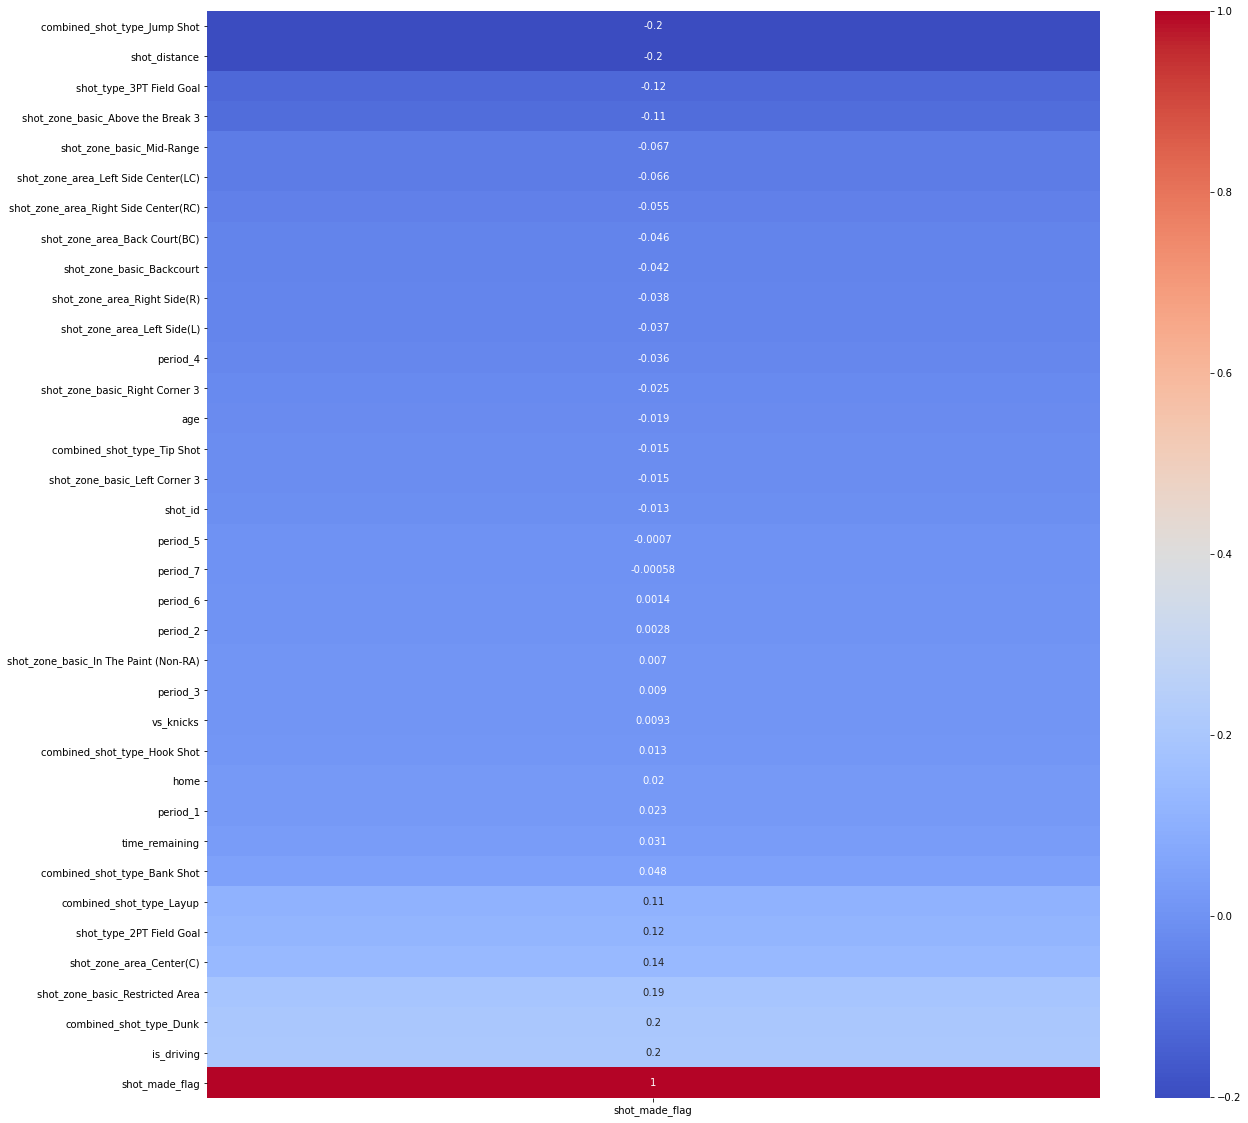

In [57]:
plt.figure(figsize = (20, 20))
sns.heatmap(df.corr()[['shot_made_flag']].sort_values(by = 'shot_made_flag'), annot = True, cmap = 'coolwarm')

In [58]:
# a function to fit and score models because I'm lazy:
def score_model(model):
    model.fit(X_train, y_train)
    print(f'train: {model.score(X_train, y_train)}')
    print(f'test: {model.score(X_test, y_test)}')

In [59]:
lr = LogisticRegressionCV(cv = 5)
score_model(lr)

train: 0.5995226234952262
test: 0.5967315175097276


This LASSO model is low variance, but the accuracy is only slightly better than my baseline of .554

In [60]:
lrr = LogisticRegressionCV(penalty = 'l1', solver = 'liblinear', cv = 5)
score_model(lrr)

train: 0.6270755500207555
test: 0.6303501945525292


The ridge classifier is a bit better than LASSO

In [61]:
knn = KNeighborsClassifier()
score_model(knn)

train: 0.6975404732254047
test: 0.5153307392996109


seems too bad to use for the model

In [62]:
rf = RandomForestClassifier()
score_model(rf)

train: 1.0
test: 0.584124513618677


unsurprisingly, the random forest classifier overfits

In [63]:
for md in [3, 5, 10, 20, 50]:
    print(f'max depth of {md} gives scores of {score_model(RandomForestClassifier(max_depth = md))}')

train: 0.6149335823993358
test: 0.6101167315175098
max depth of 3 gives scores of None
train: 0.6186176836861769
test: 0.6112062256809339
max depth of 5 gives scores of None
train: 0.6520340390203404
test: 0.6263035019455253
max depth of 10 gives scores of None
train: 0.95895599833956
test: 0.5956420233463035
max depth of 20 gives scores of None
train: 1.0
test: 0.584591439688716
max depth of 50 gives scores of None


A max depth of 10 looks very good

In [64]:
gs= GridSearchCV(
    
    RandomForestClassifier(),
    {'max_depth': [6, 7, 8, 9]}
)
gs.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [6, 7, 8, 9]})

In [65]:
gs.best_params_

{'max_depth': 7}

In [66]:
rf = RandomForestClassifier(max_depth = 8)
score_model(rf)

train: 0.6403071814030719
test: 0.6244357976653696


In [67]:
svc = SVC()
score_model(svc)

train: 0.5538605230386052
test: 0.5537743190661478


my svc is quite bad. really no better than baseline. i will not use this

In [68]:
ada = AdaBoostClassifier()
score_model(ada)

train: 0.6270755500207555
test: 0.6287937743190661


looks pretty decent. i will use this in my model

In [69]:
gb = GradientBoostingClassifier()
score_model(gb)

train: 0.6327833125778332
test: 0.6283268482490273


essentially the same performance as the adaboost model

In [70]:
gs = GridSearchCV(AdaBoostClassifier(),
                 {'learning_rate': [.01, .1, 1],
                 'n_estimators': [25, 50, 75, 100]})
score_model(gs)

train: 0.6267123287671232
test: 0.6298832684824903


In [71]:
gs.best_params_

{'learning_rate': 0.1, 'n_estimators': 100}

this really doesn't perform better than the adaboost with default hyperparameters but i'll use it anyway.

In [72]:
ada = AdaBoostClassifier(learning_rate = .1, n_estimators = 75)

In [73]:
vote = VotingClassifier([
    ('ada', ada),
    ('lasso', lr),
    ('ridge', lrr),
    ('forest', rf),
    ('gb', gb)
    
]

)
score_model(vote)

train: 0.630085097550851
test: 0.6292607003891051


probably as good as it's going to get

In [74]:
df.head()

,shot_distance,shot_made_flag,game_date,opponent,shot_id,time_remaining,home,vs_knicks,is_driving,age,combined_shot_type_Bank Shot,combined_shot_type_Dunk,combined_shot_type_Hook Shot,combined_shot_type_Jump Shot,combined_shot_type_Layup,combined_shot_type_Tip Shot,period_1,period_2,period_3,period_4,period_5,period_6,period_7,shot_type_2PT Field Goal,shot_type_3PT Field Goal,shot_zone_area_Back Court(BC),shot_zone_area_Center(C),shot_zone_area_Left Side Center(LC),shot_zone_area_Left Side(L),shot_zone_area_Right Side Center(RC),shot_zone_area_Right Side(R),shot_zone_basic_Above the Break 3,shot_zone_basic_Backcourt,shot_zone_basic_In The Paint (Non-RA),shot_zone_basic_Left Corner 3,shot_zone_basic_Mid-Range,shot_zone_basic_Restricted Area,shot_zone_basic_Right Corner 3
22901,18,0.0,1996-11-03,MIN,22902,42,True,False,False,18,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0
22902,16,0.0,1996-11-05,NYK,22903,608,False,True,False,18,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0
22903,23,1.0,1996-11-06,CHA,22904,517,False,False,False,18,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0
22904,0,0.0,1996-11-06,CHA,22905,394,False,False,False,18,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0
22905,13,1.0,1996-11-06,CHA,22906,327,False,False,False,18,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0


In [75]:
df.head()

,shot_distance,shot_made_flag,game_date,opponent,shot_id,time_remaining,home,vs_knicks,is_driving,age,combined_shot_type_Bank Shot,combined_shot_type_Dunk,combined_shot_type_Hook Shot,combined_shot_type_Jump Shot,combined_shot_type_Layup,combined_shot_type_Tip Shot,period_1,period_2,period_3,period_4,period_5,period_6,period_7,shot_type_2PT Field Goal,shot_type_3PT Field Goal,shot_zone_area_Back Court(BC),shot_zone_area_Center(C),shot_zone_area_Left Side Center(LC),shot_zone_area_Left Side(L),shot_zone_area_Right Side Center(RC),shot_zone_area_Right Side(R),shot_zone_basic_Above the Break 3,shot_zone_basic_Backcourt,shot_zone_basic_In The Paint (Non-RA),shot_zone_basic_Left Corner 3,shot_zone_basic_Mid-Range,shot_zone_basic_Restricted Area,shot_zone_basic_Right Corner 3
22901,18,0.0,1996-11-03,MIN,22902,42,True,False,False,18,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0
22902,16,0.0,1996-11-05,NYK,22903,608,False,True,False,18,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0
22903,23,1.0,1996-11-06,CHA,22904,517,False,False,False,18,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0
22904,0,0.0,1996-11-06,CHA,22905,394,False,False,False,18,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0
22905,13,1.0,1996-11-06,CHA,22906,327,False,False,False,18,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0


In [76]:
# this will take over 13 hours to run. I'll just assume it wor
preds = {}
for index in df.index:
    data = df[df.index <= index]
    data_x = df.drop(columns = ['shot_made_flag', 'opponent', 'game_date'])
    data_y = df['shot_made_flag']
    vote.fit(data_x, data_y)
    preds[index] = vote.predict(data_x[data_x.index == index])


KeyboardInterrupt: 